In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Restart CUDA
# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm

## Data

In [6]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    """
    Removes accents
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
unicodeToAscii('hola me llamó tu mamá para saber cómo estabas')

'hola me llamo tu mama para saber como estabas'

In [9]:
def join_langs(file1, file2, final_file):
    """
    Join to files in different langs to reuse the code.
    """
    
    lines1 = open(file1).readlines()
    lines2 = open(file2).readlines()
    
    file = open(final_file, 'w')
    
    for line1, line2 in zip(lines1, lines2):
        line1 = line1.replace('\n', '')
        line2 = line2.replace('\n', '')
        line = line1 + '\t' + line2 + '\n'

        file.write(line)   
        
    file.close()
    print('Finished. # of sentences: {}'.format(len(lines1)))

In [10]:
join_langs('../../data/nahuatl-spanish/train.es', 
           '../../data/nahuatl-spanish/train.nah',
           'data/es-nah.txt')

Finished. # of sentences: 16145


In [11]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [12]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [13]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(f'Input {input_lang.name} {input_lang.n_words}')
    print(f'Output {output_lang.name} {output_lang.n_words}')
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('es', 'nah', False)
print(random.choice(pairs))

Reading lines...
Read 16145 sentence pairs
Trimmed to 6379 sentence pairs
Counting words...
Counted words:
Input es 4112
Output nah 6176
['quiebraplatos', 'kaxtapan']


## Model

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training

### Preparing the data

In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [18]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [19]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

In [20]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [21]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

## Evaluation

In [22]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [23]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

In [24]:
output_lang.n_words, input_lang.n_words

(6176, 4112)

0m 33s (- 16m 19s) (2500 3%) 4.6169
1m 4s (- 14m 57s) (5000 6%) 4.2307
1m 35s (- 14m 15s) (7500 10%) 3.9650
2m 6s (- 13m 41s) (10000 13%) 3.8890
2m 37s (- 13m 5s) (12500 16%) 3.5804
3m 7s (- 12m 30s) (15000 20%) 3.5066
3m 39s (- 12m 0s) (17500 23%) 3.2851
4m 10s (- 11m 30s) (20000 26%) 3.1363
4m 42s (- 10m 59s) (22500 30%) 2.9304
5m 12s (- 10m 25s) (25000 33%) 2.7839
5m 44s (- 9m 54s) (27500 36%) 2.6397
6m 15s (- 9m 22s) (30000 40%) 2.5065
6m 46s (- 8m 51s) (32500 43%) 2.3660
7m 17s (- 8m 20s) (35000 46%) 2.2599
7m 49s (- 7m 49s) (37500 50%) 2.1968
8m 21s (- 7m 18s) (40000 53%) 2.0192
8m 52s (- 6m 47s) (42500 56%) 1.8678
9m 25s (- 6m 16s) (45000 60%) 1.8429
9m 58s (- 5m 46s) (47500 63%) 1.6489
10m 30s (- 5m 15s) (50000 66%) 1.6024
11m 2s (- 4m 44s) (52500 70%) 1.5000
11m 35s (- 4m 12s) (55000 73%) 1.3590
12m 7s (- 3m 41s) (57500 76%) 1.2662
12m 40s (- 3m 10s) (60000 80%) 1.1712
13m 11s (- 2m 38s) (62500 83%) 1.1223
13m 44s (- 2m 6s) (65000 86%) 1.0546
14m 17s (- 1m 35s) (67500 90%) 0.9

<Figure size 432x288 with 0 Axes>

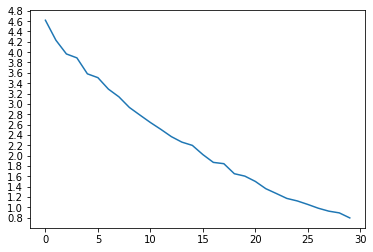

In [25]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=2500, plot_every=2500)

In [26]:
evaluateRandomly(encoder1, attn_decoder1)

> asi fue como llegaron aca los tecuanipantlacas .
= oca yhuin yn huallaque yn tequanipan tlaca .
< oca yhuin yn huallaque yn tequanipan tlaca . <EOS>

>  tu atajalo !
=  tehhua xictzacuili !
<  tehhua xictzacuili ! <EOS>

> vender
= tlanamaca
< ontlazohtlaqueh <EOS>

> cada hombre tiene tus preocupaciones .
= cocentlacatl quinpiah iyoltspacholtin .
< cocentlacatl quinpiah iyoltspacholtin . <EOS>

> aqui te voy a dar esta pequena remuneracion .
= nican nimitzmacati nehin taxtahuiltzin .
< nican nimitzmactiliti nehin . <EOS>

> otro poco
= octepitzin
< tepitzin ne <EOS>

> si hay que limpiarla .
= kemaj momeujtani .
< kemaj momeujtani . <EOS>

> azucar o miel al gusto
= tlatzopeliloni ahzo necuhtli . ixquich in monequiz
< tlatzopeliloni ahzo necuhtli . in ixquich . <EOS>

> hacia arriba
= ahcopa
< ahcopa <EOS>

> se reproduce por la semilla .
= ixua isemilla .
< ixua isemilla . <EOS>



In [27]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
#     showAttention(input_sentence, output_words, attentions)

In [35]:
input_sentence = 'rico'

output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)

Tratemos con algunas oraciones del conjunto de development.

In [74]:
input_sentence = 'ella siguio hablando'
gold_reference = 'ya quicencuilihqui tlahtoa'
output_words, _ = evaluate(encoder1, attn_decoder1, input_sentence)

print(f'Input: {input_sentence}')
print(f'Gold: {gold_reference}')
print(f'Output: {" ".join(output_words)}')

Input: ella siguio hablando
Gold: ya quicencuilihqui tlahtoa
Output: yehua ce yehua . <EOS>


In [83]:
input_sentence = 'no tengo mucho dinero en este momento'
gold_reference = 'Naman axnicpiya tomintzin.'
output_words, _ = evaluate(encoder1, attn_decoder1, input_sentence)

print(f'Input: {input_sentence}')
print(f'Gold: {gold_reference}')
print(f'Output: {" ".join(output_words)}')

Input: no tengo mucho dinero en este momento
Gold: Naman axnicpiya tomintzin.
Output: amo ce amo ce ce <EOS>


In [55]:
# ya quicencuilihqui tlahtoa.
evaluateAndShowAttention('ella siguio hablando')

# ihueltiuh in cihtli ixchipahuac catca
evaluateAndShowAttention('la hermana de la abuela no era blanca')

input = ella siguio hablando
output = yehua ce yehua . <EOS>
input = la hermana de la abuela no era blanca
output = itla ne ueyi ueyi  <EOS>


In [30]:
import sacrebleu
import argparse

In [84]:
def calculate_score_report(sys, ref, score_only):

    chrf = sacrebleu.corpus_chrf(sys, ref)
    bleu = sacrebleu.corpus_bleu(sys, ref)

    prefix = 'BLEU = ' if score_only else ''

    print('#### Score Report ####')
    print(chrf)
    print('{}{}'.format(prefix, bleu.format(score_only=score_only)))

In [98]:
system_lines = []
gold_lines = []
all_input_lines = open('../../data/nahuatl-spanish/dev.es').readlines()
all_gold_lines = open('../../data/nahuatl-spanish/dev.nah').readlines()

for i, (input_sentence, nah_sentence) in enumerate(zip(all_es_lines, all_gold_lines)):
    input_sentence = normalizeString(input_sentence)
    try:
        output_words, _ = evaluate(encoder1, attn_decoder1, input_sentence)
        output_sentence = ' '.join(output_words[0:-1])
        
        system_lines.append(output_sentence)
        gold_lines.append(nah_sentence)
    except:
        pass   

In [102]:
for sys, gold in zip(system_lines, gold_lines):
    print(f'System: {sys}')
    print(f'Gold: {gold}')

System:  in ica teca ihuan ?
Gold: ¿ticnequizquia miyac tlamantli tlacualli?

System:  tlen ueyi . amo .
Gold: ihueltiuh in cihtli ixchipahuac catca

System: yehua ce yehua .
Gold: Ya quicencuilihqui tlahtoa.

System: no komo ya . . .
Gold: zan nicpiya $20 itlamiyan queman tlaxtlahuaceh.

System: para achiyok para para para .
Gold: cualli, amo acah yetoc onpa tlen hueliz nechpalehuizqueh 

System: san kema ya .
Gold: amoqueman quiitac ihueltiuh occepa

System: amotlen para ke onca para .
Gold: amo acah onpa tlen hueliz nechpalehuizqueh

System:  in ! !
Gold: ¡Teipanoc!

System:  toni quitequipacho ? ?
Gold: ¿Tlen ticchiuhticateh ihuan tiquihtoceh?

System: amo ce amo ce ce . .
Gold: Naman axnicpiya tomintzin.

System: yehua amo amo amo .
Gold: quena cualli.

System: in tlacualli .
Gold: nicyecahcicamatic nochi cuac pehuac

System: in amo xiquelcahua nopilhuan .
Gold: amonicnequi nitlahtoz tlen notahhuan

System: san kuali ica in se kitoka .
Gold: quichiuhqueh cequin tlamantli achi ceyo

In [103]:
def calculate_score_report(sys, ref, score_only):

    chrf = sacrebleu.corpus_chrf(sys, ref)
    bleu = sacrebleu.corpus_bleu(sys, ref)

    prefix = 'BLEU = ' if score_only else ''

    print('#### Score Report ####')
    print(chrf)
    print('{}{}'.format(prefix, bleu.format(score_only=score_only)))

It is really bad.

In [110]:
calculate_score_report(system_lines, [gold_lines], score_only=True)

#### Score Report ####
chrF2 = 0.102
BLEU = 0.46
